In [1]:
import sys
import re
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import librosa.display
import IPython.display as ipd
import math
import csv
import matplotlib.pyplot as plt

ENV = 'test'
#ENV = 'publish'
MAX_AUDIO_DURATION_MS = 4 * 1000
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser(os.getcwd() + '/')
#mediapath = os.path.expanduser('/mnt/freesound-crawler/')
mediapath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/')
processedpath = os.path.join(mediapath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
excludedpath = os.path.join(processedpath, 'excluded/')
extensionpath = os.path.join(apppath, 'Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.join(mediapath, 'downloads/')
metadatapath = os.path.join(mediapath, 'metadata/')
metadatacsvpath = os.path.join(processedpath, 'metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, excludedpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'duration', 'downloads', 'rating', 'numratings', 'tags']
    rows = []

    for id in ids:        
        with open(metadatapath + "/" + id) as file:
            try:
                id = int(id)
                line = file.readlines()[0]
                arguments = line.split('|')
                duration = int(arguments[0].split('duration:')[1])
                downloads = int(arguments[1].split('downloads:')[1])
                rating = int(arguments[2].split('rating:')[1])
                numratings = int(arguments[3].split('numratings:')[1])
                tags = arguments[4].split('tags:')[1]
                row = {
                    'id': id,
                    'duration': duration,
                    'downloads': downloads,
                    'rating': rating,
                    'numratings': numratings,
                    'tags': tags
                }
                rows.append(row)
            except Exception as e:
                print(e)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 

metadata = read_csv(metadatacsvpath)

68455


In [3]:
excluded = [f for f in os.listdir(excludedpath)]
excluded = [f for f in excluded if f.endswith(audiofileformat)]
excluded = [f.split('.' + audiofileformat)[0] for f in excluded]

print(len(excluded))

1498


In [4]:
DOWNLOADS_THRESHOLD = 10
RATING_THRESHOLD = 80
MIN_NUMRATINGS = 3

scored = []
for sample in metadata:            
    id = sample['id']
    if id in excluded:
        continue

    duration = int(sample['duration'])
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    numratings = int(sample['numratings'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD and numratings >= MIN_NUMRATINGS:
        row = [id, duration, downloads, rating, numratings, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[6]))
scored.reverse()

print(scored[0])

3381
['60009', 319, 67854, 86, 561, 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 5835444]


In [5]:
samples = {}

for row in scored:
    id = row[0]
    samples[id] = {
        'duration': row[1],
        'downloads': row[2],
        'rating': row[3],
        'numratings': row[4],
        'tags': row[5],
        'score': row[6],
    }
    
print(samples[scored[0][0]])

{'duration': 319, 'downloads': 67854, 'rating': 86, 'numratings': 561, 'tags': 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 'score': 5835444}


In [6]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

for filename in filenames:
    id = filename.split('__')[0]
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
            
filenames = filtered
print('filtered filenames', len(filenames))

fileformats {'flac': 2888, 'wav': 46250, 'mp3': 2936, 'aiff': 19174, 'ogg': 679, 'm4a': 142, 'crdownload': 15, 'DS_Store': 1}
all_filenames: 72085
filtered filenames 3376


In [7]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [8]:
def process(command, cwd="/"):
    return subprocess.check_output(command, cwd=cwd)

res = []
for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat
        
        if samples[fileid]['duration'] > MAX_AUDIO_DURATION_MS:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(len(filenames))

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512389__kievinay__bass-impact-ki-01.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/512389__kievinay__bass-impact-ki-01.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60015__qubodup__writing-z-for-zorro-in-the-air.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60015__qubodup__writing-z-for-zorro-in-the-air.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49039__suspiciononline__moca-fxs-07.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49039__suspiciononline__moca-fxs-07.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/453333__kyles__metal-crank-groan.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/453333__kyles__metal-crank-groan.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/217438__unfa__hunger-noises-10.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/217438__unfa__hunger-noises-10.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67666__qubodup__voice-male-radio-take-the-shot-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67666__qubodup__voice-male-radio-take-the-shot-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60001__qubodup__air-cutting-14.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/391704__jpolito__jp-tinypadlock01.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/391704__jpolito__jp-tinypadlock01.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395349__ihitokage__leg-4.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395349__ihitokage__leg-4.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521957__kastenfrosch__wet-impact.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/521957__kastenfrosch__wet-impact.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395338__ihitokage__swish-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395338__ihitokage__swish-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpp7bommc_/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/04/l5pwchfx0r19

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/98905__kuru23__goakick01.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162459__kastenfrosch__hyperstorm.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162459__kastenfrosch__hyperstorm.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161967__qubodup__to-war-assault-drill-sergeant-shout.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161967__qubodup__to-war-assault-drill-sergeant-shout.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49026__suspiciononline__kit-hat1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49026__suspiciononline__kit-hat1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161970__qubodup__firing-mortar-at-shooting-range.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161970__qubodup__firing-mortar-at-shooting-range.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545338__stwime__beep-boop.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/545338__stwime__beep-boop.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/24122__dcdj__pop-go-beat-01.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/24122__dcdj__pop-go-beat-01.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/277646__coral-island-studios__button-1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/277646__coral-island-studios__button-1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67648__qubodup__movement-right-there-soldier-radio-talk.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395326__ihitokage__block-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395326__ihitokage__block-2.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/169727__qubodup__horror-sliding-transition.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/169727__qubodup__horror-sliding-transition.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612686__foleyhaven__pig-grunt-04.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/612686__foleyhaven__pig-grunt-04.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395350__ihitokage__slap-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60009__qubodup__swosh-22.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60000__qubodup__13th-whoosh-swing-sound.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60000__qubodup__13th-whoosh-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60014__qubodup__swosh-27.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395333__ihitokage__grab-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536736__egomassive__chop.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536736__egomassive__chop.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/450725__kyles__basketball-grab-2versions.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/450725__kyles__basketball-grab-2versions.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545373__stwime__up3.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/545373__stwime__up3.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/104357__rutgermuller__metal-glass-objects-rattling-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-15.54:measured_lra=0.0:measured_tp=2.0:measured_thresh=-27.07:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpaz5mpk1a/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/104357__rutgermuller__metal-glass-objects-rattling-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-15.54:measured_lra=0.0:measured_tp=2.0:measured_thresh=-27.07:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/104357__rutgermuller__metal-glass-objects-rattling-2.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/104357__rutgermuller__metal-glass-objects-rattling-2.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536746__egomassive__pig.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536746__egomassive__pig.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/452914__kyles__cassette-tape-rising-tone3.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/452914__kyles__cassette-tape-rising-tone3.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154888__unfa__beep-bad.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/154888__unfa__beep-bad.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395324__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395324__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60011__qubodup__whoosh-24.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60011__qubodup__whoosh-24.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536737__egomassive__chain.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536737__egomassive__chain.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395331__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395331__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162465__kastenfrosch__lostitem.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162465__kastenfrosch__lostitem.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpr045kxf7/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_meta

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/10436__batchku__gbell-7-1-pp.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203465__tesabob2001__a4.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/203465__tesabob2001__a4.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161654__qubodup__war-game-battle-level-up.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161654__qubodup__war-game-battle-level-up.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmppmdsvjej/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/04/l5pwchfx0r

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/9633__heigh-hoo__mute-1.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/391706__jpolito__jp-doorlocked04.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/391706__jpolito__jp-doorlocked04.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/448394__lordforklift__fuze-switch-flick.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/448394__lordforklift__fuze-switch-flick.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154895__unfa__drip-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/154895__unfa__drip-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162475__kastenfrosch__spacey.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162475__kastenfrosch__spacey.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/407465__loyalty-freak-music__cancel.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537816__legnalegna55__hey-hey-you.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/537816__legnalegna55__hey-hey-you.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323184__alivvie__hai-hai.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323184__alivvie__hai-hai.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395359__ihitokage__hit-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395359__ihitokage__hit-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpa74itcyb/out.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/04/l5pwchfx0r19q9rbw6m65

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/625__memexikon__duoshake.wav']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10442__batchku__gbell-3-2-ff.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.69:measured_i=-35.92:measured_lra=17.2:measured_tp=-12.02:measured_thresh=-49.13:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmplei2oo8_/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10442__batchku__gbell-3-2-ff.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.69:measured_i=-35.92:measured_lra=17.2:measured_tp=-12.02:measured_thresh=-49.13:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folde

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10442__batchku__gbell-3-2-ff.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/10442__batchku__gbell-3-2-ff.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/171619__pjkasinski3__rem-870-pump-2.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/171619__pjkasinski3__rem-870-pump-2.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67650__qubodup__voice-male-radio-auto-range-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67650__qubodup__voice-male-radio-auto-range-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=14.37:measured_i=-23.67:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-33.67:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpyfdrenj6/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=14.37:measured_i=-23.67:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-33.67:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/04/l5pw

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128261__rebeat__dish-thump.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/128261__rebeat__dish-thump.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323200__alivvie__excuse-me.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323200__alivvie__excuse-me.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/453347__kyles__metal-piece-heavy-drag-on-floor.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/453347__kyles__metal-piece-heavy-drag-on-floor.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/36115__plotzki__x-pandeiro-2bar.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.37:measured_i=-25.62:measured_lra=1.0:measured_tp=-7.03:measured_thresh=-35.62:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpn9ofkecn/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/36115__plotzki__x-pandeiro-2bar.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.37:measured_i=-25.62:measured_lra=1.0:measured_tp=-7.03:measured_thresh=-35.62:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fol

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/36115__plotzki__x-pandeiro-2bar.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/36115__plotzki__x-pandeiro-2bar.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536760__egomassive__gravel.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536760__egomassive__gravel.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422314__soneproject__35.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/422314__soneproject__35.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/534110__pbimal__rubber-ball-01.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578831__nomiqbomi__synth-wobble-20.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/578831__nomiqbomi__synth-wobble-20.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59990__qubodup__swosh-03.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59990__qubodup__swosh-03.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323198__alivvie__where-is-the-bathroom.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323198__alivvie__where-is-the-bathroom.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmplzhg7ho3/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/119077__domrodrig__door-opening-unlocking-1-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmprpiozigr/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/103998__rutgermuller__wood-knocks.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323196__alivvie__ii-high.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323196__alivvie__ii-high.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395361__ihitokage__hit-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395361__ihitokage__hit-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/340810__cabled-mess__alien-interface-communication-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536775__egomassive__rip.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536775__egomassive__rip.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10437__batchku__gbell-7-2-ff.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-33.39:measured_lra=0.0:measured_tp=-15.22:measured_thresh=-47.34:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpi6p2zkup/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10437__batchku__gbell-7-2-ff.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-33.39:measured_lra=0.0:measured_tp=-15.22:measured_thresh=-47.34:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10437__batchku__gbell-7-2-ff.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/10437__batchku__gbell-7-2-ff.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/213864__waveplaysfx__synth-seq-140-bpm-warble-pattern-dubstep.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/213864__waveplaysfx__synth-seq-140-bpm-warble-pattern-dubstep.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203481__tesabob2001__c-4.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/203481__tesabob2001__c-4.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458663__jorgerosa__light-beam-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/458663__jorgerosa__light-beam-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161340__qubodup__us-military-soldier-shouting-whoo.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161340__qubodup__us-military-soldier-shouting-whoo.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/90072__qubodup__uuh.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/90072__qubodup__uuh.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/213232__unfa__huh-haaa-dry.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/213232__unfa__huh-haaa-dry.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/415549__hullum__glitch-bass-g.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/415549__hullum__glitch-bass-g.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59996__qubodup__swoosh-wind-09.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161342__qubodup__howitzer-artillery-gun-shot-sound-effect-02.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536765__egomassive__squish.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536765__egomassive__squish.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463214__se2001__evan-s-single-bounce.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/463214__se2001__evan-s-single-bounce.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/193424__unfa__enemy-die-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/193424__unfa__enemy-die-2.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpyioroha1/out.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/04/l5pwchfx0r1

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/638__memexikon__lockjawnetb.wav']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/188488__unfa__scream-let-s-go.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/188488__unfa__scream-let-s-go.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395335__ihitokage__woosh-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395335__ihitokage__woosh-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60016__qubodup__windy-movement-29.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60016__qubodup__windy-movement-29.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67672__qubodup__voice-male-radio-yeah-3.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59995__qubodup__swosh-08.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49057__suspiciononline__moca-hat-03.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49057__suspiciononline__moca-hat-03.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/9635__heigh-hoo__open-10.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.15:measured_lra=0.0:measured_tp=-0.59:measured_thresh=-37.92:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpzfkv654h/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/9635__heigh-hoo__open-10.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.15:measured_lra=0.0:measured_tp=-0.59:measured_thresh=-37.92:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/9635__heigh-hoo__open-10.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/9635__heigh-hoo__open-10.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463818__se2001__another-chipmunk-laugh.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/463818__se2001__another-chipmunk-laugh.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459424__coral-island-studios__01-cardboard-flap.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/459424__coral-island-studios__01-cardboard-flap.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155861__unfa__alright-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/155861__unfa__alright-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpfje5ufhc/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]', '-m

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/172889__candlegravity__bell-bubbler-loop-ii.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162479__kastenfrosch__beam.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162479__kastenfrosch__beam.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521950__kastenfrosch__water-impact.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/521950__kastenfrosch__water-impact.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395347__ihitokage__slap-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59999__qubodup__sword-or-bullet-swish-swosh-12.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59999__qubodup__sword-or-bullet-swish-swosh-12.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323195__alivvie__ii-normal.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323195__alivvie__ii-normal.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmplrlii13w/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/10439__batchku__gbell-8-1-pp.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/166535__qubodup__hidden-spike-trap.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/166535__qubodup__hidden-spike-trap.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/94590__zgump__tr-loop-0501.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/94590__zgump__tr-loop-0501.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/340809__cabled-mess__retro-sci-fi-horror-06.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162469__kastenfrosch__spacey.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162469__kastenfrosch__spacey.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/435695__samsterbirdies__big-boom.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/435695__samsterbirdies__big-boom.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/277643__coral-island-studios__button-14.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/277643__coral-island-studios__button-14.mp3']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/610353__kjose__bongo-martillo-120bpm-repique1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/610353__kjose__bongo-martillo-120bpm-repique1.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323190__alivvie__complain1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323190__alivvie__complain1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67671__qubodup__voice-male-radio-yeah-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67671__qubodup__voice-male-radio-yeah-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/310710__modularsamples__roland-sh-2-noisy-sqr-filter-vel-g3-56g-2-8ui6.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.2:measured_i=-22.01:measured_lra=0.8:measured_tp=-14.87:measured_thresh=-32.01:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmp1l45l0t7/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/310710__modularsamples__roland-sh-2-noisy-sqr-filter-vel-g3-56g-2-8ui6.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.2:measured_i=-22.01:measured_lra=0.8:measured_tp=-14.87:measured_thresh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/310710__modularsamples__roland-sh-2-noisy-sqr-filter-vel-g3-56g-2-8ui6.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/310710__modularsamples__roland-sh-2-noisy-sqr-filter-vel-g3-56g-2-8ui6.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521951__kastenfrosch__weird-grunt.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/521951__kastenfrosch__weird-grunt.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/78864__lyubomir-ikonomov__min1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/78864__lyubomir-ikonomov__min1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537901__belanhud__water-squirt-single-short.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/537901__belanhud__water-squirt-single-short.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395327__ihitokage__block-1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395327__ihitokage__block-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/584179__unfa__radar.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/584179__unfa__radar.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578800__nomiqbomi__sparkle-1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/578800__nomiqbomi__sparkle-1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/399621__soundsforhim__sigh-3.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/399621__soundsforhim__sigh-3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59991__qubodup__swosh-04.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59991__qubodup__swosh-04.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmp6zaal_6c/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/119088__domrodrig__grabbing-knife-sudden-1-2.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/391702__jpolito__jp-tinypadlock03.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/391702__jpolito__jp-tinypadlock03.flac']' returned non-zero exit status 1.


0x7fd6a390bb80]
{
"input_i" : "-inf",
"input_tp" : "-inf",
"input_lra" : "0.00",
"input_thresh" : "-70.00",
"output_i" : "-inf",
"output_tp" : "-inf",
"output_lra" : "0.00",
"output_thresh" : "-70.00",
"normalization_type" : "dynamic",
"target_offset" : "inf"
}
Conversion failed!
Traceback (most recent call last):
  File "/Users/andrusasumets/.pyenv/versions/3.10.10/bin/ffmpeg-normalize", line 8, in <module>
    sys.exit(main())
  File "/Users/andrusasumets/.pyenv/versions/3.10.10/lib/python3.10/site-packages/ffmpeg_normalize/__main__.py", line 553, in main
    ffmpeg_normalize.run_normalization()
  File "/Users/andrusasumets/.pyenv/versions/3.10.10/lib/python3.10/site-packages/ffmpeg_normalize/_ffmpeg_normalize.py", line 237, in run_normalization
    raise e
  File "/Users/andrusasumets/.pyenv/versions/3.10.10/lib/python3.10/site-packages/ffmpeg_normalize/_ffmpeg_normalize.py", line 227, in run_normalization
    media_file.run_normalization()
  File "/Users/andrusasumets/.pyenv/versio

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534111__pbimal__rubber-ball-00.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/534111__pbimal__rubber-ball-00.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459433__coral-island-studios__21-cardboard-unfold.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/459433__coral-island-studios__21-cardboard-unfold.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154899__unfa__drip-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/154899__unfa__drip-2.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/209303__unfa__fireworks-big-shot-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/209303__unfa__fireworks-big-shot-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60005__qubodup__sharp-swosh-18.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60005__qubodup__sharp-swosh-18.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154903__unfa__drip-6.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/154903__unfa__drip-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/112489__cdiupe__new-12-hat-closed.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/112489__cdiupe__new-12-hat-closed.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395325__ihitokage__body-falling-on-the-ground-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395325__ihitokage__body-falling-on-the-ground-2.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.79:measured_lra=0.0:measured_tp=0.51:measured_thresh=-29.71:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpu_aykbv8/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.79:measured_lra=0.0:measured_tp=0.51:measured_thresh=-29.71:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/04/l5

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128268__rebeat__throwing-cup.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/128268__rebeat__throwing-cup.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612685__foleyhaven__pig-grunt-05.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/612685__foleyhaven__pig-grunt-05.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203460__tesabob2001__a-4.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/203460__tesabob2001__a-4.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395348__ihitokage__slap-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395348__ihitokage__slap-3.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/171615__pjkasinski3__holster-1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/171615__pjkasinski3__holster-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323205__alivvie__good-evening.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323205__alivvie__good-evening.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/415556__hullum__glitch-robot-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/415556__hullum__glitch-robot-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/171614__pjkasinski3__mag-reload-1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/171614__pjkasinski3__mag-reload-1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323203__alivvie__yoroshiku1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323203__alivvie__yoroshiku1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49051__suspiciononline__moca-style-snare-06.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49051__suspiciononline__moca-style-snare-06.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155894__unfa__yeah-4.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/155894__unfa__yeah-4.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536750__egomassive__gruntf.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536750__egomassive__gruntf.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/399626__soundsforhim__male-grunt.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/399626__soundsforhim__male-grunt.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/584181__unfa__thrust-loop.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/584181__unfa__thrust-loop.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49028__suspiciononline__kit-tamb.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/49028__suspiciononline__kit-tamb.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/448393__lordforklift__satisfying-plastic-handle-unlock.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/448393__lordforklift__satisfying-plastic-handle-unlock.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578376__nomiqbomi__shock-stab-02.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/578376__nomiqbomi__shock-stab-02.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395366__ihitokage__swish-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154905__unfa__drip-5.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/154905__unfa__drip-5.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578324__nomiqbomi__blink-02.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/578324__nomiqbomi__blink-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmp0avxrgs8/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/04/l5pw

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/128256__rebeat__dainty-break.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59989__qubodup__swosh-02.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/59989__qubodup__swosh-02.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/618994__mrrap4food__gun-silencer.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/584173__unfa__landing-forcefield.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/584173__unfa__landing-forcefield.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463817__se2001__chipmunk-laugh.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/463817__se2001__chipmunk-laugh.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536732__egomassive__caw.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/536732__egomassive__caw.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60002__qubodup__swoosh-15-windy.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/60002__qubodup__swoosh-15-windy.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/172174__unfa__beidl.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/172174__unfa__beidl.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155892__unfa__yeah-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/155892__unfa__yeah-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458665__jorgerosa__laser-shock-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/458665__jorgerosa__laser-shock-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162480__kastenfrosch__ladenaussen2.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162480__kastenfrosch__ladenaussen2.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/349655__insanity54__c4-beep1.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/349655__insanity54__c4-beep1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395360__ihitokage__hit-2.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395360__ihitokage__hit-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395344__ihitokage__leg-3.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395344__ihitokage__leg-3.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162474__kastenfrosch__ladeninnen.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162474__kastenfrosch__ladeninnen.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459426__coral-island-studios__07-cardboard-sliding-grimy.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/459426__coral-island-studios__07-cardboard-sliding-grimy.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67662__qubodup__voice-male-radio-roger-that-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67662__qubodup__voice-male-radio-roger-that-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/9637__heigh-hoo__open-3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-23.65:measured_lra=0.0:measured_tp=-3.1:measured_thresh=-43.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/tmpbtq4t1js/out.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/9637__heigh-hoo__open-3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-23.65:measured_lra=0.0:measured_tp=-3.1:measured_thresh=-43.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/9637__heigh-hoo__open-3.aiff', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/9637__heigh-hoo__open-3.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162470__kastenfrosch__sprunginnen.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162470__kastenfrosch__sprunginnen.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/233762__officialfourge__vocoded-resonant-bass.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/233762__officialfourge__vocoded-resonant-bass.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155890__unfa__oh-yeah-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/155890__unfa__oh-yeah-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/162402__qubodup__m203-grenade-launcher-1.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395362__ihitokage__hit-6.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/395362__ihitokage__hit-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67669__qubodup__voice-male-radio-who-to-engage-2.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/67669__qubodup__voice-male-radio-who-to-engage-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323199__alivvie__welcome-back.mp3', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/323199__alivvie__welcome-back.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545356__stwime__flute.ogg', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/545356__stwime__flute.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/198248__unfa__laughter-04.flac', '-o', '/Volumes/LaCie/freesound-crawler/processed/normalized/198248__unfa__laughter-04.flac']' returned non-zero exit status 1.
112


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


In [9]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            duration = samples[leftid]['duration']
            out_distances[leftid].append([correlation, duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

/Users/andrusasumets/Projects/breathic/dtw.py:28: RuntimeWarning: invalid value encountered in divide
  normalized_samples = samples / max(samples)


0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000
0 / 112000


/Users/andrusasumets/Projects/breathic/dtw.py:28: RuntimeWarning: invalid value encountered in divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/Projects/breathic/dtw.py:28: RuntimeWarning: divide by zero encountered in divide
  normalized_samples = samples / max(samples)


132


In [10]:
BREATHE_OUT_FREQUENCY_MULTIPLIER = 0.5
saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue

    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    target_breathe_in = extensionsamplepath + leftid + '-breathe-in.' + audiofileformat
    target_breathe_out = extensionsamplepath + leftid + '-breathe-out.' + audiofileformat

    try:
        process(['ffmpeg', '-i', source, '-af', 'silenceremove=1:0:-50dB', target_breathe_in, '-y'])
        process(['ffmpeg', '-i', target_breathe_in, '-af', 'asetrate=44100*' + str(BREATHE_OUT_FREQUENCY_MULTIPLIER) + ',aresample=44100,atempo=1/' + str(BREATHE_OUT_FREQUENCY_MULTIPLIER), '-y', target_breathe_out])

    except Exception as e:
        print(e)
        pass

    saved.append(leftid)

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

Output #0, ipod, to '/Users/andrusasumets/Projects/breathic/Extension/data/samples/406735-breathe-out.m4a':
  Metadata:
    major_brand     : M4A 
    minor_version   : 512
    compatible_brands: M4A isomiso2
    date            : 2017-10-29
    encoder         : Lavf59.27.100
  Stream #0:0(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, mono, fltp, 69 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc59.37.100 aac
size=       5kB time=00:00:00.51 bitrate=  73.3kbits/s speed=  43x    
video:0kB audio:4kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 24.620708%
[aac @ 0x7fcf01205cc0] Qavg: 11755.857
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --ena

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

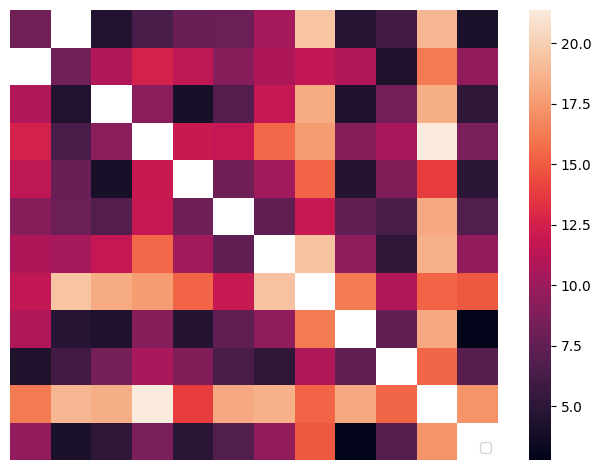

In [11]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()

In [12]:
def show_sample(comparison):
    distance, leftid, rightid = comparison
    print(distance, leftid, rightid)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_sample(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_sample(full_distances[i - display_count])

2.7793226214056417 425727 8835


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_22877/232571163.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
/Users/andrusasumets/.pyenv/versions/3.10.10/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_22877/232571163.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)


3.9659866510225665 13858 186947


4.041328628472435 220178 8835


4.301595353559396 220156 406735


4.347090250636452 13858 425727


18.54093856421101 18082 190096


18.8239639775566 18082 220178


19.381227315954856 190096 433824


19.452906956757737 220178 433824


21.365821705145816 18082 325270


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_22877/3778201453.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(path)


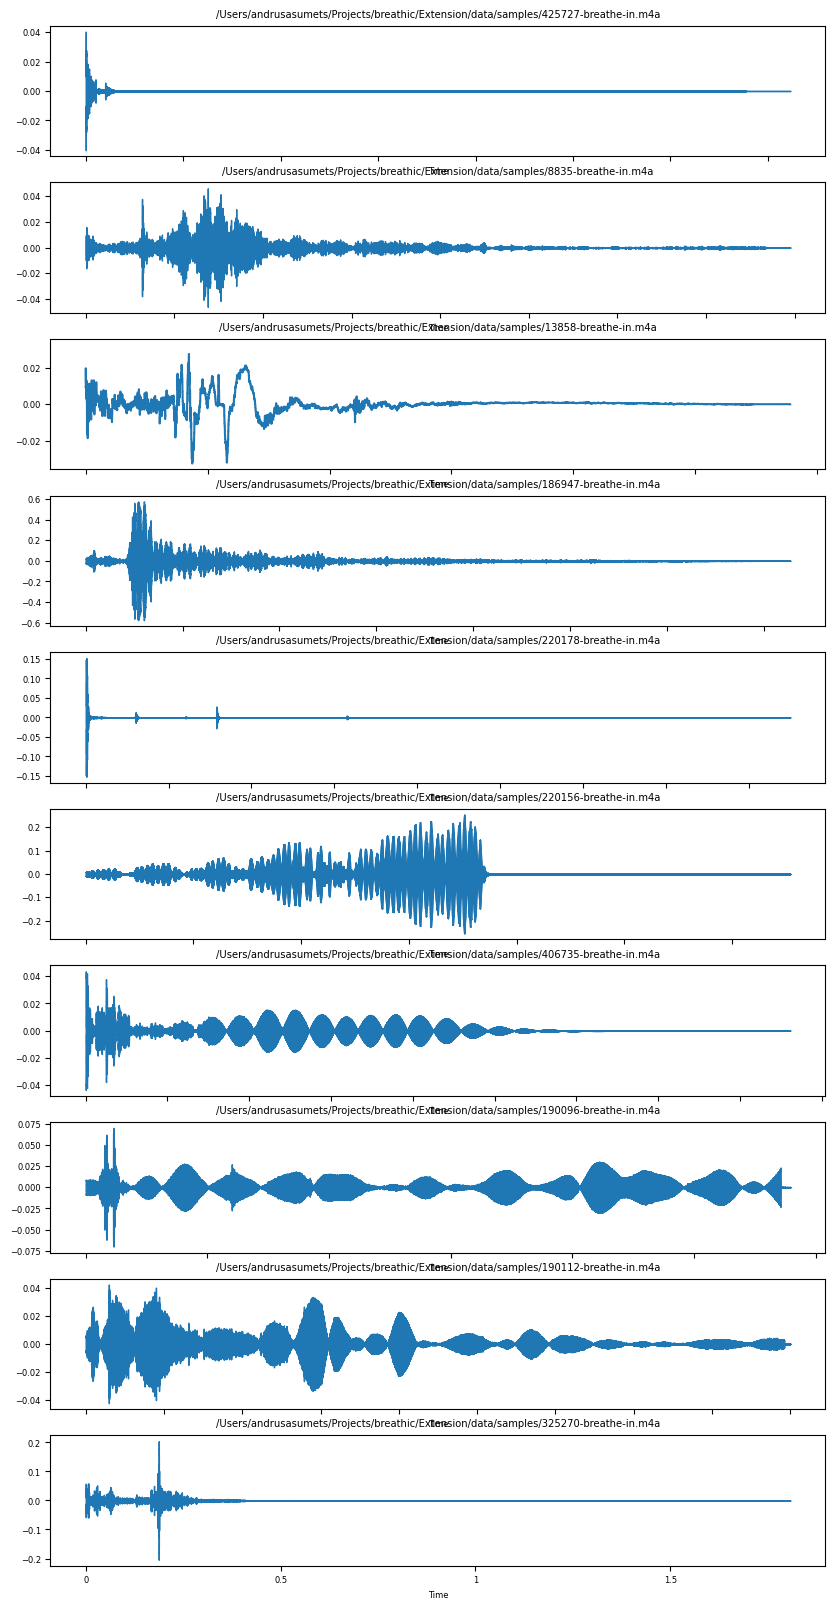

In [13]:
plots = saved[0:10]
plt.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(nrows=len(plots), figsize=(10, 20))

def waveform(path, idx):
    data, rate = librosa.core.load(path)
    sub_ax = ax[idx]
    sub_ax.set_title(path)
    sub_ax.label_outer()
    librosa.display.waveshow(data, sr=rate, ax=sub_ax)

for idx, leftid in enumerate(plots):
    waveform(extensionsamplepath + leftid + '-breathe-in.' + audiofileformat, idx)